# Machine Learning Layer
#### Goal: Estimate the next beta

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tf as tf
from plotnine import *

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

from tensorflow import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import RootMeanSquaredError

## 1) Import Data:
CSV file can be found in Teams under Model/ML_for_Beta/all_matrix_data.csv

In [3]:
df = pd.read_csv('../../../../Assets/Data/all_matrix_data_v2.csv', index_col=0)

In [4]:
df.sort_values('beta')

,week,policy_index,variant,mobility,temperature,wind,infections,beta,beta_t_minus_1,start_date_forecasting,district
92,94,59.95,0,-1.428571,8.814286,19.942857,11.489796,6.026915e-22,6.933729,2022-01-03,Stadt Zweibrücken
81,83,53.57,B.1.617.2,5.857143,5.728571,6.428571,12.377551,3.619277e-21,6.510024,2021-10-18,Memmingen
91,93,83.93,B.1.617.2,6.285714,0.757143,13.357143,14.540816,6.570606e-21,8.331957,2021-12-27,Kaufbeuren
4,6,65.18,Other,-22.428571,13.314286,12.971429,4.714286,4.776496e-20,0.605319,2020-04-27,Essen
11,13,57.44,Other,-4.571429,14.614286,10.914286,1.622449,4.990339e-20,0.752731,2020-06-15,Aichach-Friedberg
...,...,...,...,...,...,...,...,...,...,...,...
72,74,67.86,B.1.617.2,0.142857,19.328571,12.714286,1.918367,1.262921e+01,0.000002,2021-08-16,Weimarer Land
67,69,73.21,B.1.617.2,19.571429,18.085714,9.900000,1.408163,1.627833e+01,0.009034,2021-07-12,Ahrweiler
64,66,73.21,B.1.1.7,0.428571,21.100000,5.771429,0.612245,1.925268e+01,0.013506,2021-06-21,Dillingen a.d.Donau
61,63,75.12,B.1.1.7,10.857143,10.100000,16.585714,0.704082,2.020258e+01,0.020218,2021-05-31,Wesermarsch


## 2) Visualize Data:
#### 2.1) Average Infections (training period):

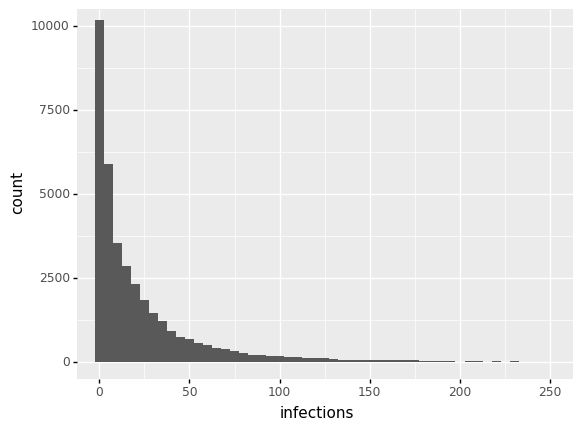

<ggplot: (379426557)>

In [5]:
ggplot(df, aes(x='infections')) + geom_histogram(binwidth=5) + coord_cartesian(xlim=(0,250),ylim=(0,10000))

#### 2.2) Fitted beta:

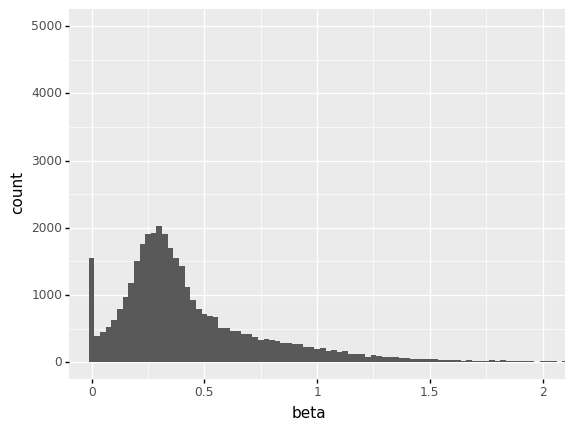

<ggplot: (379682416)>

In [6]:
ggplot(df, aes(x='beta')) + geom_histogram(binwidth=0.025) + coord_cartesian(xlim=(0,2),ylim=(0,5000))

#### 2.3) Average infections Münster

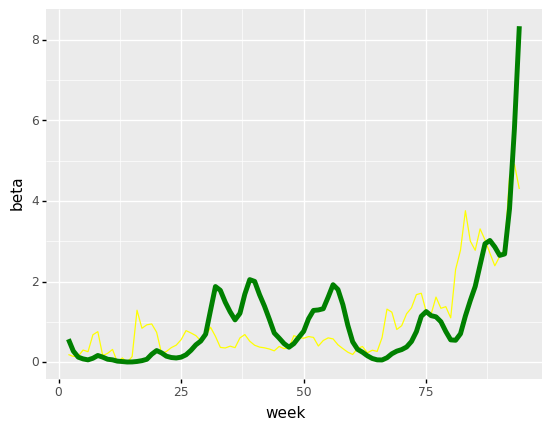

<ggplot: (343612269)>

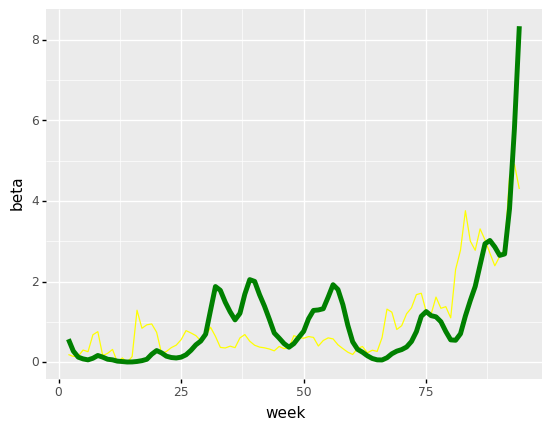

<ggplot: (343215147)>

In [12]:
district = 'Münster'
df_v2_3 = df[df['district']==district][['week','district','infections','beta']]

# Devide both columns by their mean so that they fit in one plot:
df_v2_3['infections'] = df_v2_3['infections']/df_v2_3['infections'].mean()
df_v2_3['beta'] = df_v2_3['beta']/df_v2_3['beta'].mean()

ggplot(df_v2_3) \
+ geom_line(aes(x='week', y='beta'), color='yellow')\
+ geom_line(aes(x='week', y='infections'), color='green', size=2)

#### 2.4) Policy index vs infections: (Germany)

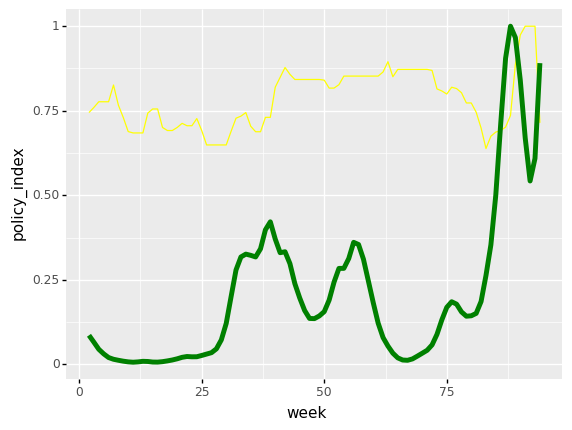

<ggplot: (343490244)>

In [13]:
df_v2_4 = df.groupby('week').sum()

# Devide both columns by their max so that they fit in one plot:
df_v2_4['infections'] = df_v2_4['infections']/df_v2_4['infections'].max()
df_v2_4['policy_index'] = df_v2_4['policy_index']/df_v2_4['policy_index'].max()

ggplot(df_v2_4.reset_index())\
+ geom_line(aes(x='week', y='policy_index'), color='yellow')\
+ geom_line(aes(x='week', y='infections'), color='green', size=2)

## 3) Feature Engineering:
#### Lagged beta: (NO LONGER NECESSARY!)

In [7]:
# Sort values by district and week before lagging:
df.sort_values(['district','week'], inplace=True)

In [8]:
# Check out correlation between current and previous weeks beta:
df['beta'].corr(df['beta_t_minus_1'] )

0.47832132020327517

## 4) Data cleaning:
#### Identify missing values:

In [10]:
df.isnull().sum()

week                         0
policy_index                 0
variant                      0
mobility                     0
temperature                236
wind                      3739
infections                   0
beta                         0
beta_t_minus_1               0
start_date_forecasting       0
district                     0
dtype: int64

#### Fill missing values with previous column:
Forward fill: Fill down (-> if missing value in week 50 use value of week 49)

In [11]:
df_v4 = df.copy()

In [12]:
df_v4['temperature'] = df.groupby("week").transform(lambda x: x.fillna(x.mean()))['temperature']
df_v4['wind'] = df.groupby("week").transform(lambda x: x.fillna(x.mean()))['wind']

/var/folders/f9/_57rk_kx5jqbkd8vvnwckf2c0000gn/T/ipykernel_20447/1409488165.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
/var/folders/f9/_57rk_kx5jqbkd8vvnwckf2c0000gn/T/ipykernel_20447/1409488165.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.


In [13]:
df_v4

,week,policy_index,variant,mobility,temperature,wind,infections,beta,beta_t_minus_1,start_date_forecasting,district
0,2,62.500000,Other,-41.714286,5.171429,14.975758,52.469388,0.279336,0.323306,2020-03-30,Aachen
1,3,63.778571,Other,-34.428571,5.914286,11.157143,36.877551,0.144479,0.378790,2020-04-06,Aachen
2,4,65.180000,Other,-29.285714,15.071429,10.571429,25.244898,0.190455,0.180074,2020-04-13,Aachen
3,5,65.180000,Other,-32.857143,11.085714,11.071429,16.683673,0.180385,0.177962,2020-04-20,Aachen
4,6,65.180000,Other,-23.714286,13.500000,17.157143,8.091837,0.062952,0.251573,2020-04-27,Aachen
...,...,...,...,...,...,...,...,...,...,...,...
88,90,81.761429,B.1.617.2,-9.714286,1.757143,17.071429,412.040816,0.498803,0.447938,2021-12-06,Zwickau
89,91,83.930000,B.1.617.2,-2.571429,0.428571,8.528571,305.561224,0.437243,0.520256,2021-12-13,Zwickau
90,92,83.930000,B.1.617.2,-1.000000,4.842857,10.485714,202.959184,0.377533,0.509719,2021-12-20,Zwickau
91,93,83.930000,B.1.617.2,-4.285714,-1.200000,10.700000,143.448980,0.511456,0.393324,2021-12-27,Zwickau


## 5) Outlier removal:


In [14]:
# Identify outliers:

In [17]:
df_v4[df_v4['infections'] > 10].sort_values('beta_t_minus_1', ascending=True)

,week,policy_index,variant,mobility,temperature,wind,infections,beta,beta_t_minus_1,start_date_forecasting,district
3,5,65.180000,Other,-28.428571,12.542857,11.685714,10.887755,2.785730e-02,0.001777,2020-04-20,Regionalverband Saarbrücken
43,45,70.710000,Other,-0.142857,2.742857,18.042857,38.428571,2.246029e-01,0.009794,2021-01-25,Mansfeld-Südharz
27,29,54.460000,Other,17.142857,10.942857,9.785714,12.112245,9.797257e-01,0.017700,2020-10-05,Berchtesgadener Land
36,38,61.310000,Other,-4.142857,2.657143,14.200000,12.316327,6.285718e-01,0.029280,2020-12-07,Wilhelmshaven
61,63,75.120000,B.1.1.7,-5.428571,12.414286,14.985714,15.295918,2.284658e-01,0.041091,2021-05-31,Regionalverband Saarbrücken
...,...,...,...,...,...,...,...,...,...,...,...
84,86,58.040000,B.1.617.2,-3.714286,7.671429,17.071429,34.581633,5.782073e+00,7.691740,2021-11-08,"Bayreuth, Stadt"
73,75,67.092857,B.1.617.2,3.000000,16.785714,10.000000,19.397959,4.412497e+00,8.215394,2021-08-23,Schwäbisch Hall
91,93,83.930000,B.1.617.2,6.285714,0.757143,13.357143,14.540816,6.570606e-21,8.331957,2021-12-27,Kaufbeuren
84,86,58.040000,B.1.617.2,54.714286,8.000000,13.071429,32.663265,4.521375e+00,8.510537,2021-11-08,Frankfurt (Oder)


#### 5.1) Infection counts:
Remove weeks in which the average number of daily infections where below a threshold as for extremely low values it is really hard to forecast beta:

In [18]:
# Drop all rows in which average number of infections is below 5:
threshold = 10
df_v5_1 = df_v4[df_v4['infections'] > threshold]

#### 5.2) Beta values:

In [19]:
# Drop all rows in which the beta value is < 0.025:
threshold = 0.025
df_v5_2 = df_v5_1[df_v5_1['beta'] > threshold]

## 6) Preprocessing columns:
#### 6.1) Handling categorical columns:

In [28]:
# Only use week and district as index columns:
df_v6_1 = df_v5_2.set_index(['week','district','start_date_forecasting'])

In [29]:
# One hot-encode variant columns:
df_v6_2_a = pd.get_dummies(df_v6_1['variant'])
df_v6_2_b = df_v6_1.drop(columns='variant', axis=1)

df_v6_2_c = pd.concat([df_v6_2_a,df_v6_2_b], axis=1)

In [30]:
# Drop "other" variant column to prevent dummy variable trap:
df_v6_2_d = df_v6_2_c.drop(columns='Other', axis=1)

In [31]:
# Drop zero column:
df_v6_2_e = df_v6_2_d.drop(columns='0', axis=1)

In [32]:
df_v6_2_e

,,,B.1.1.7,B.1.617.2,policy_index,mobility,temperature,wind,infections,beta,beta_t_minus_1
week,district,start_date_forecasting,,,,,,,,,
2,Aachen,2020-03-30,0,0,62.500000,-41.714286,5.171429,14.975758,52.469388,0.279336,0.323306
3,Aachen,2020-04-06,0,0,63.778571,-34.428571,5.914286,11.157143,36.877551,0.144479,0.378790
4,Aachen,2020-04-13,0,0,65.180000,-29.285714,15.071429,10.571429,25.244898,0.190455,0.180074
5,Aachen,2020-04-20,0,0,65.180000,-32.857143,11.085714,11.071429,16.683673,0.180385,0.177962
25,Aachen,2020-09-07,0,0,58.032857,4.000000,15.171429,10.200000,11.132653,0.584775,0.181417
...,...,...,...,...,...,...,...,...,...,...,...
90,Zwickau,2021-12-06,0,1,81.761429,-9.714286,1.757143,17.071429,412.040816,0.498803,0.447938
91,Zwickau,2021-12-13,0,1,83.930000,-2.571429,0.428571,8.528571,305.561224,0.437243,0.520256
92,Zwickau,2021-12-20,0,1,83.930000,-1.000000,4.842857,10.485714,202.959184,0.377533,0.509719


#### 6.2) Standardizing:

In [33]:
# Standardize:
scaler_obj = StandardScaler()

# Split explanatory columns from beta:
explanatory_cols = df_v6_2_e.drop(columns=['beta','beta_t_minus_1'], axis=1)
beta_cols = df_v6_2_e[['beta','beta_t_minus_1']]

# Apply scaling:
scaled_explanatory_cols = pd.DataFrame(scaler_obj.fit_transform(explanatory_cols), index=explanatory_cols.index, columns=explanatory_cols.columns)

# Merge both together again:
df_v6_3 = pd.concat([scaled_explanatory_cols, beta_cols], axis=1)
df_v6_3

,,,B.1.1.7,B.1.617.2,policy_index,mobility,temperature,wind,infections,beta,beta_t_minus_1
week,district,start_date_forecasting,,,,,,,,,
2,Aachen,2020-03-30,-0.692338,-0.751908,-0.623553,-2.627390,-0.323276,0.947990,-0.012034,0.279336,0.323306
3,Aachen,2020-04-06,-0.692338,-0.751908,-0.453805,-2.123714,-0.187870,-0.065911,-0.187156,0.144479,0.378790
4,Aachen,2020-04-13,-0.692338,-0.751908,-0.267746,-1.768177,1.481269,-0.221427,-0.317811,0.190455,0.180074
5,Aachen,2020-04-20,-0.692338,-0.751908,-0.267746,-2.015078,0.754764,-0.088670,-0.413968,0.180385,0.177962
25,Aachen,2020-09-07,-0.692338,-0.751908,-1.216627,0.532931,1.499497,-0.320047,-0.476315,0.584775,0.181417
...,...,...,...,...,...,...,...,...,...,...,...
90,Zwickau,2021-12-06,-0.692338,1.329949,1.933664,-0.415165,-0.945623,1.504422,4.026563,0.498803,0.447938
91,Zwickau,2021-12-13,-0.692338,1.329949,2.221571,0.078635,-1.187791,-0.763837,2.830617,0.437243,0.520256
92,Zwickau,2021-12-20,-0.692338,1.329949,2.221571,0.187271,-0.383167,-0.244186,1.678222,0.377533,0.509719


## 7) Modeling
### 7.1) Preparation
#### 7.1.1) Split into train/val:

In [34]:
df_modeling = df_v6_3
df_modeling

,,,B.1.1.7,B.1.617.2,policy_index,mobility,temperature,wind,infections,beta,beta_t_minus_1
week,district,start_date_forecasting,,,,,,,,,
2,Aachen,2020-03-30,-0.692338,-0.751908,-0.623553,-2.627390,-0.323276,0.947990,-0.012034,0.279336,0.323306
3,Aachen,2020-04-06,-0.692338,-0.751908,-0.453805,-2.123714,-0.187870,-0.065911,-0.187156,0.144479,0.378790
4,Aachen,2020-04-13,-0.692338,-0.751908,-0.267746,-1.768177,1.481269,-0.221427,-0.317811,0.190455,0.180074
5,Aachen,2020-04-20,-0.692338,-0.751908,-0.267746,-2.015078,0.754764,-0.088670,-0.413968,0.180385,0.177962
25,Aachen,2020-09-07,-0.692338,-0.751908,-1.216627,0.532931,1.499497,-0.320047,-0.476315,0.584775,0.181417
...,...,...,...,...,...,...,...,...,...,...,...
90,Zwickau,2021-12-06,-0.692338,1.329949,1.933664,-0.415165,-0.945623,1.504422,4.026563,0.498803,0.447938
91,Zwickau,2021-12-13,-0.692338,1.329949,2.221571,0.078635,-1.187791,-0.763837,2.830617,0.437243,0.520256
92,Zwickau,2021-12-20,-0.692338,1.329949,2.221571,0.187271,-0.383167,-0.244186,1.678222,0.377533,0.509719


#### 7.1.2) Split into train val:

In [35]:
SEED = 420

In [36]:
X_full = df_modeling.drop(columns=['beta'], axis=1)
y_full = df_modeling['beta']

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, shuffle=True, train_size=0.75, random_state=SEED)

### 7.2 Models
#### 7.2.1) Baseline Approach: Choosing previous beta

In [38]:
# Baseline approach would be to use the beta from the previous week for the next week:
## Therefore we have to compare how well this works, compared to our ML approach:
y_pred_baseline = X_val['beta_t_minus_1']

In [39]:
# Correlation of this approach:
X_full['beta_t_minus_1'].corr(y_full)

0.8527094146409695

In [40]:
pd.DataFrame({'y_val':y_val, 'y_pred_baseline':y_pred_baseline})

,,,y_val,y_pred_baseline
week,district,start_date_forecasting,,
37,Altenburger Land,2020-11-30,0.435493,0.346312
36,Vogtlandkreis,2020-11-23,0.470760,0.285459
85,Dillingen a.d.Donau,2021-11-01,0.903822,1.293763
88,Mecklenburgische Seenplatte,2021-11-22,1.081504,0.963231
56,Oberhausen,2021-04-12,0.397448,0.343429
...,...,...,...,...
81,Steinfurt,2021-10-04,1.322626,1.029713
44,Wolfenbüttel,2021-01-18,0.363532,0.344318
32,Alzey-Worms,2020-10-26,0.521762,0.344621


In [41]:
# Compute RMSE of baseline approach:
rmse_baseline =  mean_squared_error(y_val, y_pred_baseline, squared=False)
print(f'Baseline RMSE is: {rmse_baseline}')

Baseline RMSE is: 0.38160385225644416


#### 7.2.2) Multivariate Linear Regression

In [42]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred_linreg = regr.predict(X_val)
rmse_linreg = mean_squared_error(y_val, y_pred_linreg, squared=False)

In [43]:
print(f'RMSE of {regr} is: {rmse_linreg}. This is an improvement compared to the baseline approach of: {-(rmse_linreg / rmse_baseline -1)*100} %')

RMSE of LinearRegression() is: 0.36830792114253086. This is an improvement compared to the baseline approach of: 3.484223504373385 %


#### 7.2.3) Ridge Regression:

In [44]:
ridge_reg = linear_model.Ridge()
ridge_reg.fit(X_train, y_train)

y_pred_ridge_reg = ridge_reg.predict(X_val)
rmse_ridge_reg = mean_squared_error(y_val, y_pred_ridge_reg, squared=False)

In [45]:
print(f'RMSE of {ridge_reg} is: {rmse_ridge_reg}. This is an improvement compared to the baseline approach of: {-(rmse_ridge_reg / rmse_baseline -1)*100} %')

RMSE of Ridge() is: 0.3683011189683511. This is an improvement compared to the baseline approach of: 3.4860060267822957 %


#### 7.2.4) Random Forest Regressor:

In [46]:
rfg_model = RandomForestRegressor()
rfg_model.fit(X_train, y_train)

y_pred_random_forest = rfg_model.predict(X_val)
rmse_random_forest = mean_squared_error(y_val, y_pred_random_forest, squared=False)

In [47]:
print(f'RMSE of {rfg_model} is: {rmse_random_forest}. This is an improvement compared to the baseline approach of: {-(rmse_random_forest / rmse_baseline -1)*100} %')

RMSE of RandomForestRegressor() is: 0.3113211811898339. This is an improvement compared to the baseline approach of: 18.417704813781377 %


#### 7.2.5) Support Vector Machines

In [48]:
svm = SVR()
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_val)
rmse_svm = mean_squared_error(y_val, y_pred_svm, squared=False)

In [49]:
print(f'RMSE of {svm} is: {rmse_svm}. This is an improvement compared to the baseline approach of: {-(rmse_svm / rmse_baseline -1)*100} %')

RMSE of SVR() is: 0.31030865333494184. This is an improvement compared to the baseline approach of: 18.683039623402642 %


#### 7.2.6) XGBoost

In [50]:
xgb_model = xgb.XGBRegressor(verbosity=0)
xgb_model.name = 'XGBoostRegressor'
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_val)
rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False)

In [51]:
print(f'\n RMSE of {xgb_model.name} is: {rmse_xgb}. This is an improvement compared to the baseline approach of: {-(rmse_xgb / rmse_baseline -1)*100} %')


 RMSE of XGBoostRegressor is: 0.3124732092818247. This is an improvement compared to the baseline approach of: 18.115813707289963 %


In [52]:
pd.DataFrame({'beta_opt':y_val, 'last_beta':y_pred_baseline, 'xgb_bred':y_pred_xgb})

,,,beta_opt,last_beta,xgb_bred
week,district,start_date_forecasting,,,
37,Altenburger Land,2020-11-30,0.435493,0.346312,0.379993
36,Vogtlandkreis,2020-11-23,0.470760,0.285459,0.359751
85,Dillingen a.d.Donau,2021-11-01,0.903822,1.293763,0.995141
88,Mecklenburgische Seenplatte,2021-11-22,1.081504,0.963231,0.917967
56,Oberhausen,2021-04-12,0.397448,0.343429,0.359269
...,...,...,...,...,...
81,Steinfurt,2021-10-04,1.322626,1.029713,0.872739
44,Wolfenbüttel,2021-01-18,0.363532,0.344318,0.240399
32,Alzey-Worms,2020-10-26,0.521762,0.344621,0.410312


#### 7.2.7) Neural Network

In [53]:
ann_model = Sequential([
    Dense(24, input_dim=len(X_train.columns), activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])


# compile model:
ann_model.compile(
    loss = 'mse',
    optimizer = 'adam',
    metrics=[RootMeanSquaredError(name='rmse')]
)

2022-01-22 23:59:17.526593: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [54]:
history = ann_model.fit(X_train,
                        y_train,
                        epochs=20,
                        # class_weight=class_weight,
                        validation_data=(X_val, y_val),
                        )

Epoch 1/20
451/451 [==============================] - 2s 2ms/step - loss: 0.5053 - rmse: 0.7109 - val_loss: 0.2046 - val_rmse: 0.4524
Epoch 2/20
451/451 [==============================] - 0s 977us/step - loss: 0.2473 - rmse: 0.4973 - val_loss: 0.1415 - val_rmse: 0.3761
Epoch 3/20
451/451 [==============================] - 0s 942us/step - loss: 0.1936 - rmse: 0.4400 - val_loss: 0.1247 - val_rmse: 0.3531
Epoch 4/20
451/451 [==============================] - 0s 969us/step - loss: 0.1817 - rmse: 0.4262 - val_loss: 0.1328 - val_rmse: 0.3645
Epoch 5/20
451/451 [==============================] - 0s 940us/step - loss: 0.1659 - rmse: 0.4073 - val_loss: 0.1302 - val_rmse: 0.3608
Epoch 6/20
451/451 [==============================] - 0s 935us/step - loss: 0.1611 - rmse: 0.4013 - val_loss: 0.1235 - val_rmse: 0.3514
Epoch 7/20
451/451 [==============================] - 0s 946us/step - loss: 0.1607 - rmse: 0.4009 - val_loss: 0.1264 - val_rmse: 0.3556
Epoch 8/20
451/451 [==============================

In [55]:
y_pred_ann = ann_model.predict(X_val)
rmse_ann = mean_squared_error(y_val, y_pred_ann, squared=False)

In [56]:
print(f'RMSE of {ann_model} is: {rmse_ann}. This is an improvement compared to the baseline approach of: {-(rmse_ann / rmse_baseline -1)*100} %')

RMSE of <keras.engine.sequential.Sequential object at 0x169ef0ca0> is: 0.3316070343835079. This is an improvement compared to the baseline approach of: 13.101759213724485 %
